In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print(tf.__version__)

1.2.0


## Classification pipeline

Here we try to predict mu, the trend of the input sequence which is a noisy Brownian motion.

In [2]:
batch_size = 128
d_x = 1
n_classes = 3

## Making room for the sequences

Let's create placeholders for our input data x and output data y.

In [3]:
# We do not assume we know the sequence length yet

x_seq_ph = tf.placeholder(shape=(batch_size, None, d_x), dtype=tf.float32)
seq_class_ph = tf.placeholder(shape=(batch_size, 1), dtype=tf.int32)

## Preparing the network's modules

Let's define a convolution layer

In [4]:
def convolution_layer(input_seq, n_dims_in, n_dims_out, width, 
                      dilation=1):
    conv_kernel = tf.get_variable(
        name="kernel",
        shape=[width, n_dims_in, n_dims_out], 
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer())
    conv_output = tf.nn.convolution(
        input=input_seq,
        filter=conv_kernel,
        padding="SAME",
        strides=None,
        dilation_rate=[dilation]
    )
    return conv_output

## A simple model for classication

Let's build a classifier consisting of an order p convolution filter followed by an average.

In [5]:
p = 2

with tf.variable_scope("AR_p_model"):
    y_predicted = convolution_layer(x_seq_ph, d_x, n_classes, width=p)
    logit = tf.reduce_mean(y_predicted, axis=1)

In [6]:
seq_label = tf.one_hot(seq_class_ph, n_classes)

loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=seq_label, logits=logit))

In [7]:
learning_rate = 1e-3

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss)

## Generating Brownians with trends

In [16]:
def generate_samples(batch_size, sequence_length, n_dims):
    trend = np.random.normal(0.0, 1.0, (batch_size, 1, 1))
    trend_sign = np.sign(trend) + 1
    seq = np.cumsum(trend 
                    + np.random.normal(0.0, 1.0, (batch_size, 
                                                  sequence_length, 
                                                  n_dims)),
                    axis=1)
    return seq, trend_sign[:,:,0]

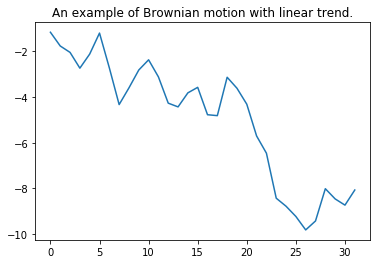

In [20]:
plt.plot(generate_samples(1, 32, 1)[0][0,:,:])
plt.title("An example of Brownian motion with linear trend.")
plt.show()

## Let's train o

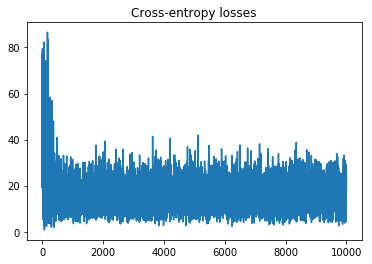

In [21]:
n_steps = int(1e4)
sequence_length = 128

session = tf.Session()

session.run(tf.global_variables_initializer())

loss_evals = []

for step in xrange(n_steps):
    x_seq, trend_sign = generate_samples(batch_size, sequence_length, d_x)
    loss_eval, _ = session.run((loss, optimizer), 
                               feed_dict={x_seq_ph: x_seq, 
                                          seq_class_ph: trend_sign})

    loss_evals.append(loss_eval)
    
plt.plot(loss_evals)
plt.title("Cross-entropy losses")
plt.show()

In [10]:
variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="AR_p_model")

print([v.name for v in variables])
kernel = [v for v in variables if "kernel" in v.name.split('/')[-1]][0]

kernel_eval = session.run(kernel)

[u'AR_p_model/kernel:0', u'AR_p_model/kernel/RMSProp:0', u'AR_p_model/kernel/RMSProp_1:0']


## What does the kernel look like?

Here, we try to detect the trend of Brownian motion.
We have X_(t+1) - X(t) ~ N(trend, sigma).
Therefore, we expect our kernel to unravel first level differences.

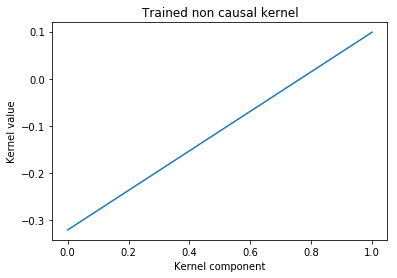

In [14]:
plt.plot(kernel_eval[:,0,0])
plt.title("Trained non causal kernel")
plt.ylabel("Kernel value")
plt.xlabel("Kernel component")
plt.show()